# **Imports**



In [1]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score
from scipy.stats import mstats
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier


# **Load dataset**

In [2]:
train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Enzyme-Substrate/train.csv')
test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Enzyme-Substrate/test.csv')

**Drop unnecessary columns**

In [3]:
# drop columns
train = train.drop(['id', 'EC3', 'EC4', 'EC5', 'EC6'], axis="columns")
test = test.drop(['id'], axis="columns")

# **Detecting and winsorizing outliers**

In [4]:
for col in train.columns:
  # Calculate the interquartile range (IQR)
  Q1 = np.percentile(train[col], 25)
  Q3 = np.percentile(train[col], 75)
  IQR = Q3 - Q1

  # Define the lower and upper bounds for outliers
  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR

  # Identify outliers
  outliers = (train[col] < lower_bound) | (train[col] > upper_bound)

  if np.any(outliers):
    train[col] = mstats.winsorize(train[col], limits=0.1)

# **Binning**

In [5]:
# Perform equal-width binning
num_bins = 5

for col in train.drop(['EC1', 'EC2'], axis="columns").columns:
  bin_edges = np.linspace(np.min(train[col]), np.max(train[col]), num_bins + 1)
  bin_labels = range(num_bins)
  binned_data = pd.cut(train[col], bins=bin_edges, labels=bin_labels, include_lowest=True)
  binned_col_name = col + "_binned"
  train[binned_col_name] = binned_data

for col in test.columns:
  bin_edges = np.linspace(np.min(test[col]), np.max(test[col]), num_bins + 1)
  bin_labels = range(num_bins)
  binned_data = pd.cut(test[col], bins=bin_edges, labels=bin_labels, include_lowest=True)
  binned_col_name = col + "_binned"
  test[binned_col_name] = binned_data

# **MinMaxScaling numerical features (0-1)**

In [6]:
# BertzCT Chi1 Chi1n Chi1v Chi2n Chi2v Chi3v Chi4n EState_VSA1 EState_VSA2 ExactMolWt FpDensityMorgan1 FpDensityMorgan2 FpDensityMorgan3 HallKierAlpha HeavyAtomMolWt Kappa3 MaxAbsEStateIndex MinEStateIndex
# NumHeteroatoms PEOE_VSA10 PEOE_VSA14 PEOE_VSA6 PEOE_VSA7 PEOE_VSA8 SMR_VSA10 SMR_VSA5 SlogP_VSA3 VSA_EState9 fr_COO fr_COO2
scaler = MinMaxScaler()
for col in train.columns:
  if col == 'EC1' or col == "EC2":
    pass
  else:
    train[col] = scaler.fit_transform(train[[col]])

scaler = MinMaxScaler()
for col in test.columns:
  if col == 'EC1' or col == "EC2":
    pass
  else:
    test[col] = scaler.fit_transform(test[[col]])

**Drop unnecessary columns**

In [7]:
X = train
xtest = test

# **Preparing the targets**

In [8]:
train['target'] = train['EC1'].apply(lambda x: len(train['EC1']))
i = 0
while i < np.array(train).size:
  if i == 14838:
    break
  elif train['EC1'][i] == 1 and train['EC2'][i] == 1:
    train['target'][i] = 3
  elif train['EC1'][i] == 1 and train['EC2'][i] == 0:
    train['target'][i] = 2
  elif train['EC1'][i] == 0 and train['EC2'][i] == 1:
    train['target'][i] = 1
  elif train['EC1'][i] == 0 and train['EC2'][i] == 0:
    train['target'][i] = 0

  i += 1
y = train['target']

<ipython-input-8-647bf42e3b2e>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['target'][i] = 3
<ipython-input-8-647bf42e3b2e>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['target'][i] = 1
<ipython-input-8-647bf42e3b2e>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['target'][i] = 2
<ipython-input-8-647bf42e3b2e>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

Se

# **Dropping highly correlated columns**

In [ ]:
#def correlation(dataset, threshold):
#    col_corr = set()  # Set of all the names of correlated columns
#    corr_matrix = dataset.corr()
#    for i in range(len(corr_matrix.columns)):
#        for j in range(i):
#            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
#                colname = corr_matrix.columns[i]  # getting the name of column
#                col_corr.add(colname)
#    return col_corr

In [ ]:
#corr_cols = correlation(X, 0.85)
#corr_cols = correlation(xtest, 0.85)
#X = X.drop(corr_cols, axis="columns")
#xtest = xtest.drop(corr_cols, axis="columns")

# **Computing Covariance**

In [9]:
# We then compute the covariance matrix using the cov() function provided by pandas. The resulting covariance matrix is stored in the cov_matrix variable.
# Next, we set a threshold (threshold) to determine which variables to modify based on covariance values. In this case, any absolute covariance value greater than 10 will trigger the modification.
# We iterate through the upper triangular portion of the covariance matrix and check if the absolute covariance value exceeds the threshold. If so, we identify the column names colname_i and colname_j
# corresponding to the variables involved in the high covariance. Then, we modify the values in column colname_j by adding the values from column colname_i.

def compute_covariance(df, threshold=0.6):
  cov_matrix = df.cov()
  for i in range(len(cov_matrix.columns)):
      for j in range(i+1, len(cov_matrix.columns)):
          if abs(cov_matrix.iloc[i, j]) > threshold:
              colname_i = cov_matrix.columns[i]
              colname_j = cov_matrix.columns[j]
              df[colname_j] = df[colname_j] + df[colname_i]

  return df

In [10]:
df = compute_covariance(X)
dfxtest = compute_covariance(xtest)

# **Train-Test Split**

In [11]:
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2, random_state=42)

In [12]:
X_train.shape

(11870, 65)

# **Deep Learning**

In [25]:
def baseline_model():
  model = Sequential()
  model.add(Dense(units=1000, input_dim=65, activation="relu"))
  model.add(Dense(units=4, activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model
estimator = KerasClassifier(build_fn=baseline_model, epochs=100, batch_size=5, verbose=0)

<ipython-input-25-fac8b339ecfd>:7: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  estimator = KerasClassifier(build_fn=baseline_model, epochs=100, batch_size=5, verbose=0)


In [26]:
kfold = KFold(n_splits=3, shuffle=True)
results = cross_val_score(estimator, X_test, y_test, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Baseline: 100.00% (0.00%)


# **Statistical Methods**

In [13]:
lr = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=42)
lr.fit(X_train, y_train)
lr.score(X_test, y_test)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


1.0

In [14]:
dtc = DecisionTreeClassifier(random_state=42)
dtc.fit(X_train, y_train)
dtc.score(X_test, y_test)

1.0

In [15]:
knc = KNeighborsClassifier()
knc.fit(X_train, y_train)
knc.score(X_test, y_test)

0.9973045822102425

In [16]:
rfc = RandomForestClassifier(random_state=42)
rfc.fit(X_train, y_train)
rfc.score(X_test, y_test)

1.0

In [17]:
svc = SVC(kernel="poly", random_state=42)
svc.fit(X_train, y_train)
svc.score(X_test, y_test)

1.0

In [18]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)
gnb.score(X_test, y_test)

1.0

In [19]:
ensemble_model = VotingClassifier(estimators=[('lr', lr), ('dt', dtc), ('knc', knc), ('rfc', rfc), ('svc', svc), ('gnb', gnb)], voting='hard')

# Train the ensemble model
ensemble_model.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


VotingClassifier(estimators=[('lr',
                              LogisticRegression(multi_class='multinomial',
                                                 random_state=42)),
                             ('dt', DecisionTreeClassifier(random_state=42)),
                             ('knc', KNeighborsClassifier()),
                             ('rfc', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(kernel='poly', random_state=42)),
                             ('gnb', GaussianNB())])

In [20]:
ensemble_model.score(X_test, y_test)

1.0

# **Visualizations**

array([[<Axes: title={'center': 'BertzCT'}>,
        <Axes: title={'center': 'Chi1'}>,
        <Axes: title={'center': 'Chi1n'}>,
        <Axes: title={'center': 'Chi1v'}>,
        <Axes: title={'center': 'Chi2n'}>,
        <Axes: title={'center': 'Chi2v'}>,
        <Axes: title={'center': 'Chi3v'}>,
        <Axes: title={'center': 'Chi4n'}>],
       [<Axes: title={'center': 'EState_VSA1'}>,
        <Axes: title={'center': 'EState_VSA2'}>,
        <Axes: title={'center': 'ExactMolWt'}>,
        <Axes: title={'center': 'FpDensityMorgan1'}>,
        <Axes: title={'center': 'FpDensityMorgan2'}>,
        <Axes: title={'center': 'FpDensityMorgan3'}>,
        <Axes: title={'center': 'HallKierAlpha'}>,
        <Axes: title={'center': 'HeavyAtomMolWt'}>],
       [<Axes: title={'center': 'Kappa3'}>,
        <Axes: title={'center': 'MaxAbsEStateIndex'}>,
        <Axes: title={'center': 'MinEStateIndex'}>,
        <Axes: title={'center': 'NumHeteroatoms'}>,
        <Axes: title={'center': 'PEOE_V

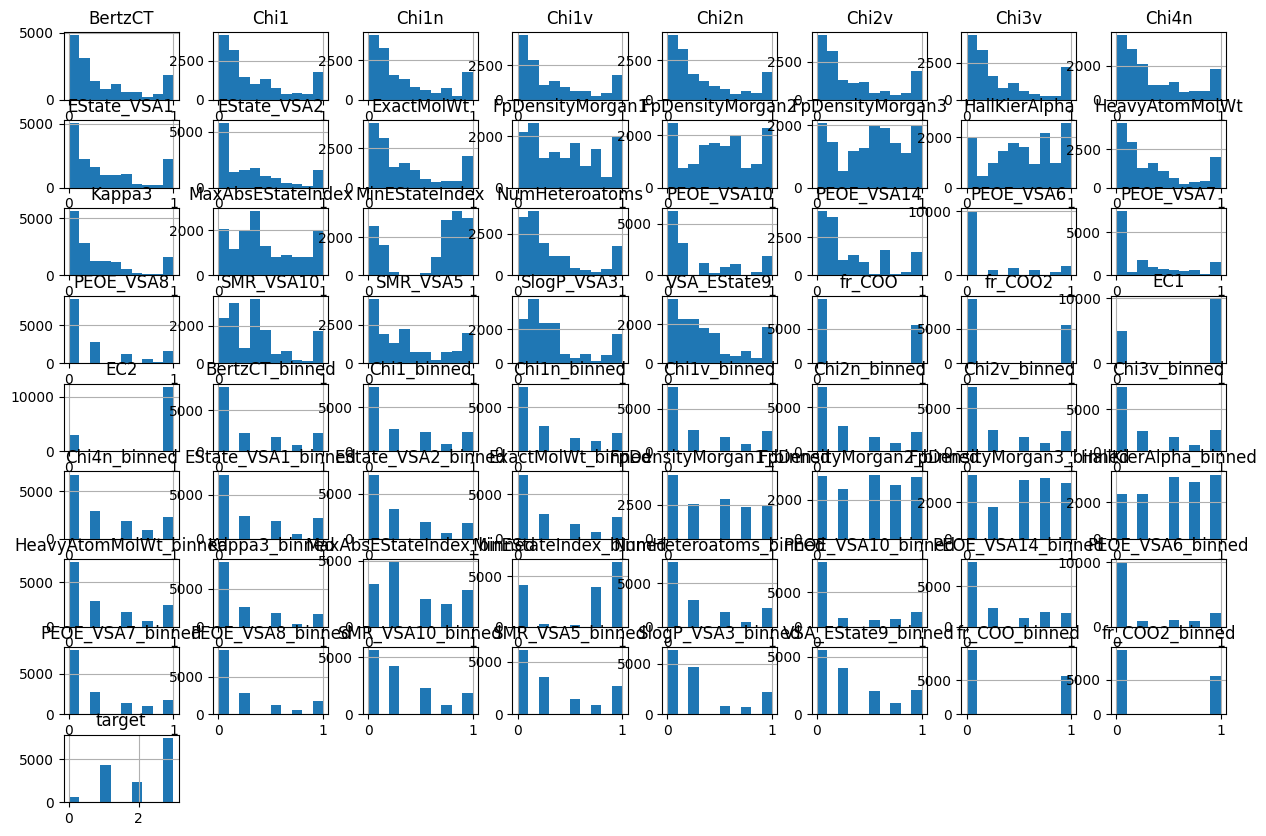

In [21]:
X.hist(figsize=(15,10))

In [22]:
sb.pairplot(train.drop(['Chi1v', 'Chi2n', 'Chi2v', 'Chi3v', 'Chi4n',
       'EState_VSA1', 'EState_VSA2', 'ExactMolWt', 'FpDensityMorgan1',
       'FpDensityMorgan2', 'FpDensityMorgan3', 'HallKierAlpha',
       'HeavyAtomMolWt', 'Kappa3', 'MaxAbsEStateIndex', 'MinEStateIndex',
       'NumHeteroatoms', 'PEOE_VSA10', 'PEOE_VSA14', 'PEOE_VSA6', 'PEOE_VSA7',
       'PEOE_VSA8', 'SMR_VSA10', 'SMR_VSA5', 'SlogP_VSA3', 'VSA_EState9',
       'fr_COO', 'fr_COO2', 'EC1', 'EC2'], axis="columns"), hue="target")

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-b8809b714c17>", line 1, in <cell line: 1>
    sb.pairplot(train.drop(['Chi1v', 'Chi2n', 'Chi2v', 'Chi3v', 'Chi4n',
  File "/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py", line 2114, in pairplot
    grid = PairGrid(data, vars=vars, x_vars=x_vars, y_vars=y_vars, hue=hue,
  File "/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py", line 1358, in __init__
    self.tight_layout(pad=layout_pad)
  File "/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py", line 118, in tight_layout
    self._figure.tight_layout(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/matplotlib/figure.py", line 3509, in tight_layout
    engine.execute(self)
  File "/usr/local/lib/python3.10/dist-packages/matplotlib/layout_engine.py", line 178, in execute

TypeError: ignored

Error in callback <function _draw_all_if_interactive at 0x7f1aa8df20e0> (for post_execute):


KeyboardInterrupt: ignored

Error in callback <function flush_figures at 0x7f1aa8df1360> (for post_execute):


KeyboardInterrupt: ignored

In [ ]:
plt.figure(figsize=(20, 15))
sb.heatmap(X.corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()